# Human Action Recognition using 3D CNN
### A mini project by

Sourabh Sathe

MT23MCS003

MTech CSE

VNIT


Training a 3D convolutional neural network (CNN) for video classification using the UCF101 action recognition dataset. 3D CNN kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions.

# Init

In [2]:
# pip install remotezip tqdm opencv-python einops
import tensorflow as tf
import tqdm
import random
import pathlib
# import itertools
import collections
import os
import cv2
# import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import keras
from keras import layers

In [3]:
# Testing presence of GPU and set memory growth
print(tf.__version__)


from tensorflow.python.client import device_lib
gpu_devices = [device for device in device_lib.list_local_devices() if device.device_type == "GPU"]

print(gpu_devices if gpu_devices else "No GPU devices found.")

# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

2.10.1
[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2238133044
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1605911925905320095
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Download UCF101 dataset

Preparing subsets from UCF101 dataset (10 labels)

In [4]:
def list_files_per_class(zip_url):
    # Returns List of files in each of the classes.
    files = []
    with rz.RemoteZip(zip_url) as zip:
        for zip_info in zip.infolist():
            files.append(zip_info.filename)
    return files


def get_class(fname):
    # Returns Class that the file belongs to.
    return fname.split("_")[-3]


def get_files_per_class(files):
    # Returns Dictionary of class names (key) and files (values).

    files_for_class = collections.defaultdict(list)
    for fname in files:
        class_name = get_class(fname)
        files_for_class[class_name].append(fname)
    return files_for_class


def download_from_zip(zip_url, to_dir, file_names):
    # Download the contents of the zip file from the zip URL.
    with rz.RemoteZip(zip_url) as zip:
        for fn in tqdm.tqdm(file_names):
            class_name = get_class(fn)
            zip.extract(fn, str(to_dir / class_name))
            unzipped_file = to_dir / class_name / fn

            fn = pathlib.Path(fn).parts[-1]
            output_file = to_dir / class_name / fn
            unzipped_file.rename(
                output_file,
            )


def split_class_lists(files_for_class, count):
    # Returns the list of files belonging to a subset of data as well as the remainder of
    # files that need to be downloaded.
    split_files = []
    remainder = {}
    for cls in files_for_class:
        split_files.extend(files_for_class[cls][:count])
        remainder[cls] = files_for_class[cls][count:]
    return split_files, remainder


def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
    # Download a subset of the UFC101 dataset and split them into various parts, such as
    # training, validation, and test.

    files = list_files_per_class(zip_url)
    for f in files:
        tokens = f.split("/")
        if len(tokens) <= 2:
            files.remove(f)

    files_for_class = get_files_per_class(files)

    classes = list(files_for_class.keys())[:num_classes]

    for cls in classes:
        new_files_for_class = files_for_class[cls]
        random.shuffle(new_files_for_class)
        files_for_class[cls] = new_files_for_class

    # Only use the number of classes you want in the dictionary
    files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

    # dirs = {}
    for split_name, split_count in splits.items():
        print(split_name, ":")
        split_dir = download_dir / split_name
        split_files, files_for_class = split_class_lists(files_for_class, split_count)
        download_from_zip(zip_url, split_dir, split_files)
        # dirs[split_name] = split_dir

    # return dirs


dataset_dir = pathlib.Path("./UCF101_subset10/")

if os.path.exists(dataset_dir):
    print("Dataset already exists")
    # Do something else if needed
else:
    URL = "https://storage.googleapis.com/thumos14_files/UCF101_videos.zip"
    download_ufc_101_subset(URL, num_classes=10, splits={"train": 30, "val": 10, "test": 10}, download_dir=dataset_dir)

# subset_paths = {"train": f"{dataset_dir}/train", "val": f"{dataset_dir}/val", "test": f"{dataset_dir}/test"}
subset_paths = {"train": dataset_dir / "train", "val": dataset_dir / "val", "test": dataset_dir / "test"}

Dataset already exists


# Preprocessing video data



In [5]:
def format_frames(frame, output_size):
    # Pad and resize an image from a video.

  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):  #TRY CHANGING OUTPUT SIZE AND FRAME_STEP

    # Creates frames from each video file present for each category. Returns A NumPy array of frames in the shape of (n_frames, height, width, channels).

  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encoding labels
      yield video_frames, label

In [6]:
##EXPERIMENT WITH THIS.
n_frames = 10  # DEFAULT WAS 10
batch_size = 2  # DEFAULT WAS 8

# dimensions of one frame in the set of frames created
HEIGHT = 100   #DEFAULT WAS 224
WIDTH = 100

Creating training, validation, and test sets

In [7]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

# Batch the data
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

# Creating Model

Uses 3D ResNet which operate on video volume (time, height, width)
But instead of using 3D convolutions, it uses (2 + 1)D convolution with residual connections. The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this decomposition is that it saves parameters.

The 3D convolution operation is takes (time * height * width * channels) inputs and produces channels outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of (3 x 3 x 3) would need a weight-matrix with (27 * channels ^ 2) entries.

While in the (2 + 1)D convolution, the spatial convolution takes in data of the shape (1, width, height), while the temporal convolution takes in data of the shape (time, 1, 1). For example, a (2 + 1)D convolution with kernel size (3 x 3 x 3) would need weight matrices of size (9 * channels ^ 2) + (3 * channels ^ 2) = (12 * channels^2), less than half as many as the full 3D convolution.

In [23]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
#    Sequence of 3D convolutional layers: first over the spatial dimensions, and then the temporal dimension.
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)
  

A ResNet model is made from a sequence of residual blocks. A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through. The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch. Gradients flow easily through this branch. Therefore, an easy path from the loss function to any of the residual block's main branch will be present. This avoids the vanishing gradient problem.

Instead of Conv2D, we use our custom Conv2Plus1D layer in the main branch of the residual block.

In [9]:
class ResidualMain(keras.layers.Layer):
    # Residual block -> convolution+layer normalization+relu activation

  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The Project layer below deals with cases where the number of channels is changed on the branch.

In [10]:
class Project(keras.layers.Layer):
    # Projects dimensions of the tensor as the data is passed through different sized filters and downsampled.
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [11]:
def add_residual_block(input, filters, kernel_size):
#  This block introduces a skip connection between the layers of the model
  out = ResidualMain(filters,kernel_size)(input)

  res = input
# project the last dimension of the tensor to match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing layer -> to perform downsampling, discarding non-essential information, dimensionality reduction and faster processing

In [12]:
class ResizeVideo(keras.layers.Layer):
    def __init__(self, height, width):
        super().__init__()
        self.height = height
        self.width = width
        self.resizing_layer = layers.Resizing(self.height, self.width)

    def call(self, video):
        # b = batch size,
        # t = time,
        # h = height,
        # w = width
        # c = number of channels.
        shape = tf.shape(video)
        b, t, h, w, c = shape[0], shape[1], shape[2], shape[3], shape[4]
        images = tf.reshape(video, [-1, h, w, c])
        images = self.resizing_layer(images)
        videos = tf.reshape(images, [b, t, self.height, self.width, c])
        return videos

Building the residual network

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))

x = input
x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)  #TRY CHANGING THIS to MAXPOOL
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

frames, label = next(iter(train_ds))
model.build(frames)

Visualize the model

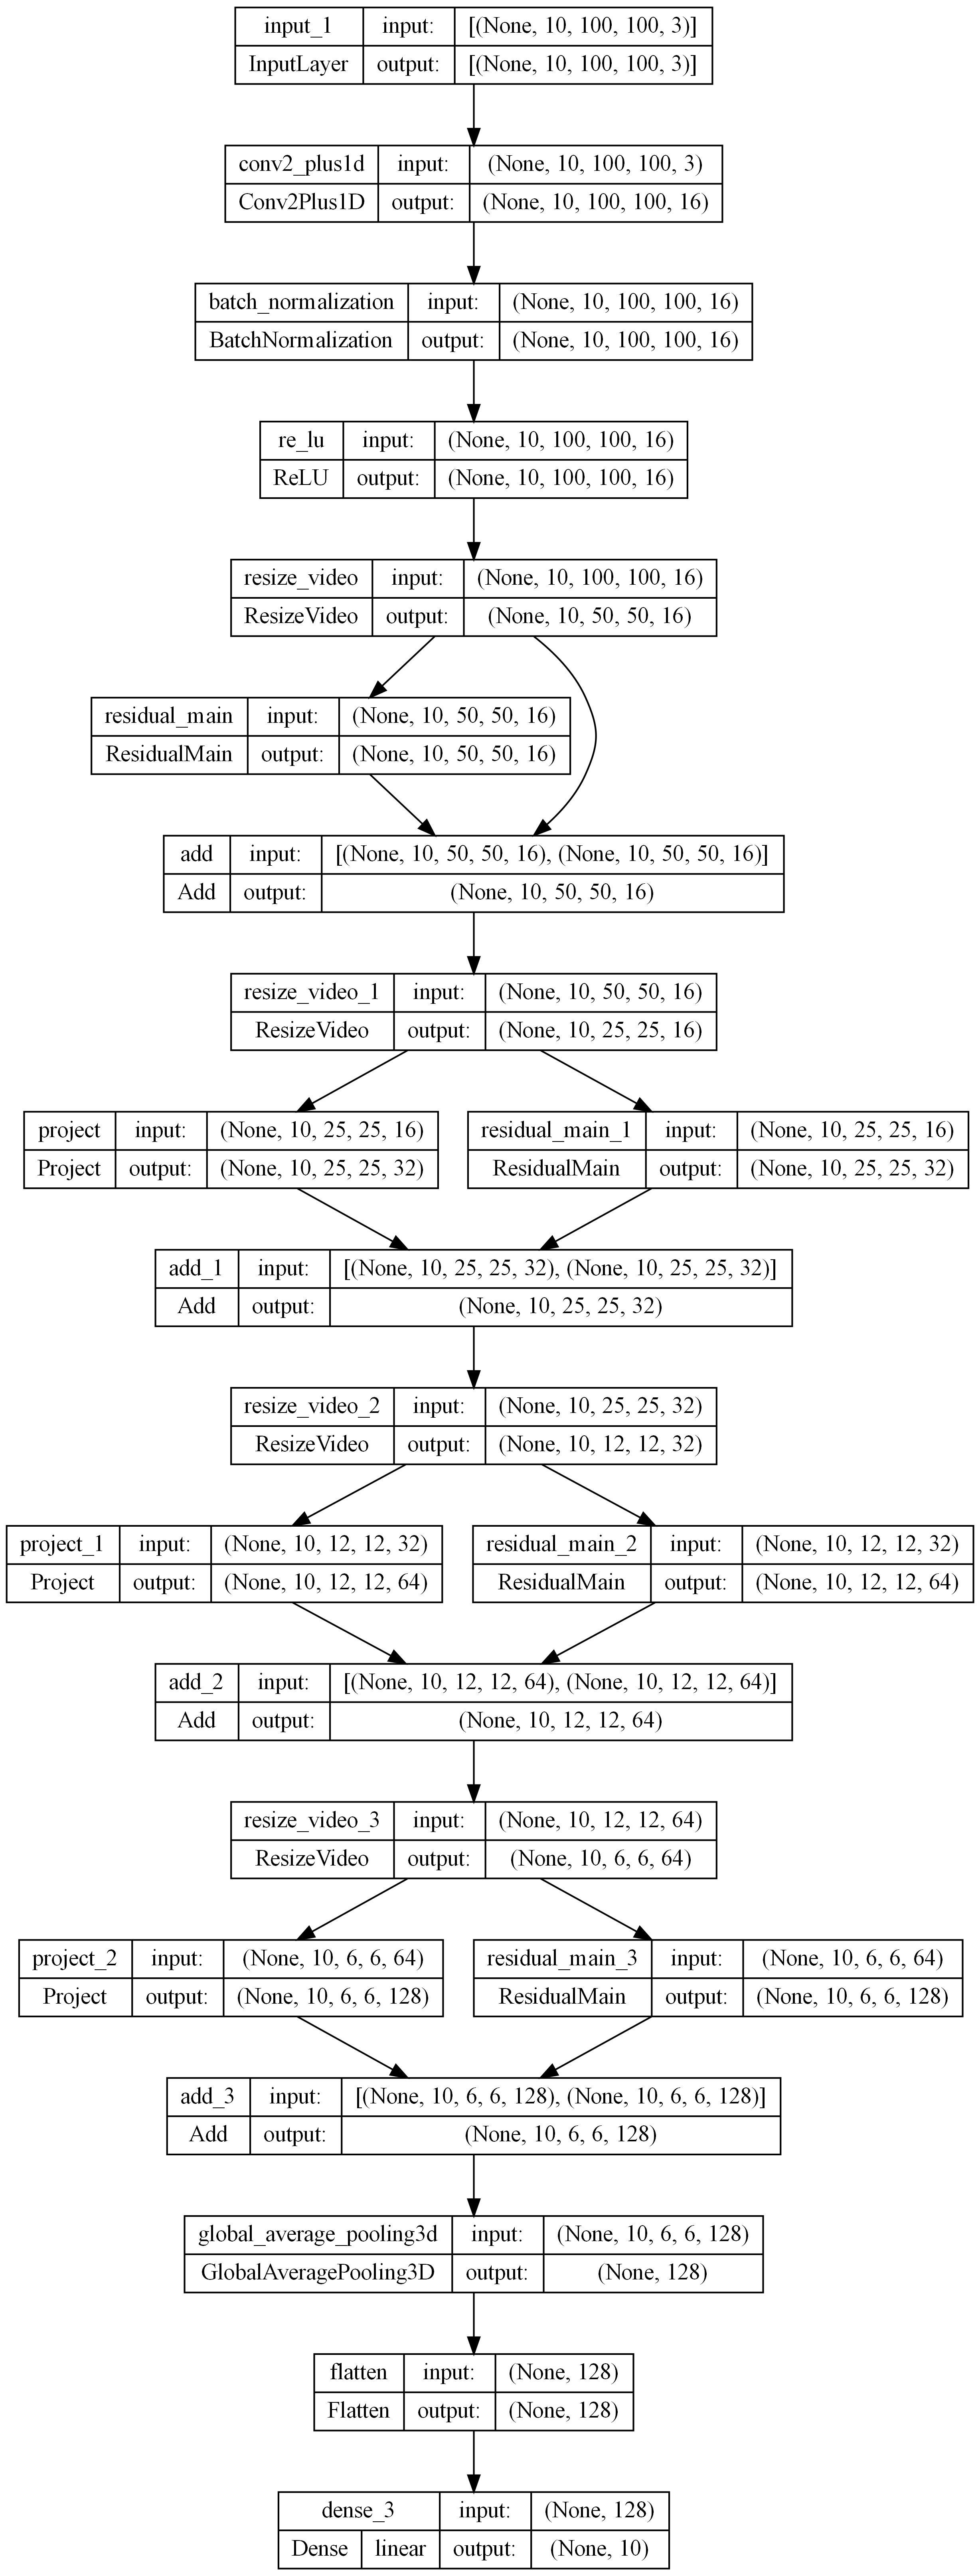

In [14]:
keras.utils.plot_model(model, dpi=300,show_shapes=True,show_layer_activations=True,expand_nested=True)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 100, 10  0           []                               
                                0, 3)]                                                            
                                                                                                  
 conv2_plus1d (Conv2Plus1D)     (None, 10, 100, 100  3152        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 100, 100  64         ['conv2_plus1d[0][0]']           
 alization)                     , 16)                                                         

# Training

Loss fn = SparseCategoricalCrossentropy
Optimizer = Adam
Learning Rate = 0.0001

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

In [17]:
# with tf.device("/CPU"):
#     history = model.fit(x=train_ds, epochs=1, validation_data=val_ds)

In [18]:
with tf.device('/GPU:0'):
    history = model.fit(x = train_ds,epochs = 50,validation_data = val_ds)

Epoch 1/50
150/150 [==============================] - 79s 432ms/step - loss: 2.3751 - accuracy: 0.1867 - val_loss: 2.4388 - val_accuracy: 0.1300
Epoch 2/50
150/150 [==============================] - 58s 388ms/step - loss: 2.1078 - accuracy: 0.2067 - val_loss: 2.1421 - val_accuracy: 0.2500
Epoch 3/50
150/150 [==============================] - 58s 388ms/step - loss: 2.0087 - accuracy: 0.2667 - val_loss: 1.8996 - val_accuracy: 0.2900
Epoch 4/50
150/150 [==============================] - 57s 382ms/step - loss: 1.8087 - accuracy: 0.3367 - val_loss: 1.7256 - val_accuracy: 0.3700
Epoch 5/50
150/150 [==============================] - 58s 384ms/step - loss: 1.6887 - accuracy: 0.3633 - val_loss: 1.5124 - val_accuracy: 0.4100
Epoch 6/50
150/150 [==============================] - 58s 388ms/step - loss: 1.5750 - accuracy: 0.4300 - val_loss: 1.6561 - val_accuracy: 0.3900
Epoch 7/50
150/150 [==============================] - 57s 383ms/step - loss: 1.5438 - accuracy: 0.4433 - val_loss: 1.6499 - val_ac

# Visualizing training data

Plots of loss and accuracy

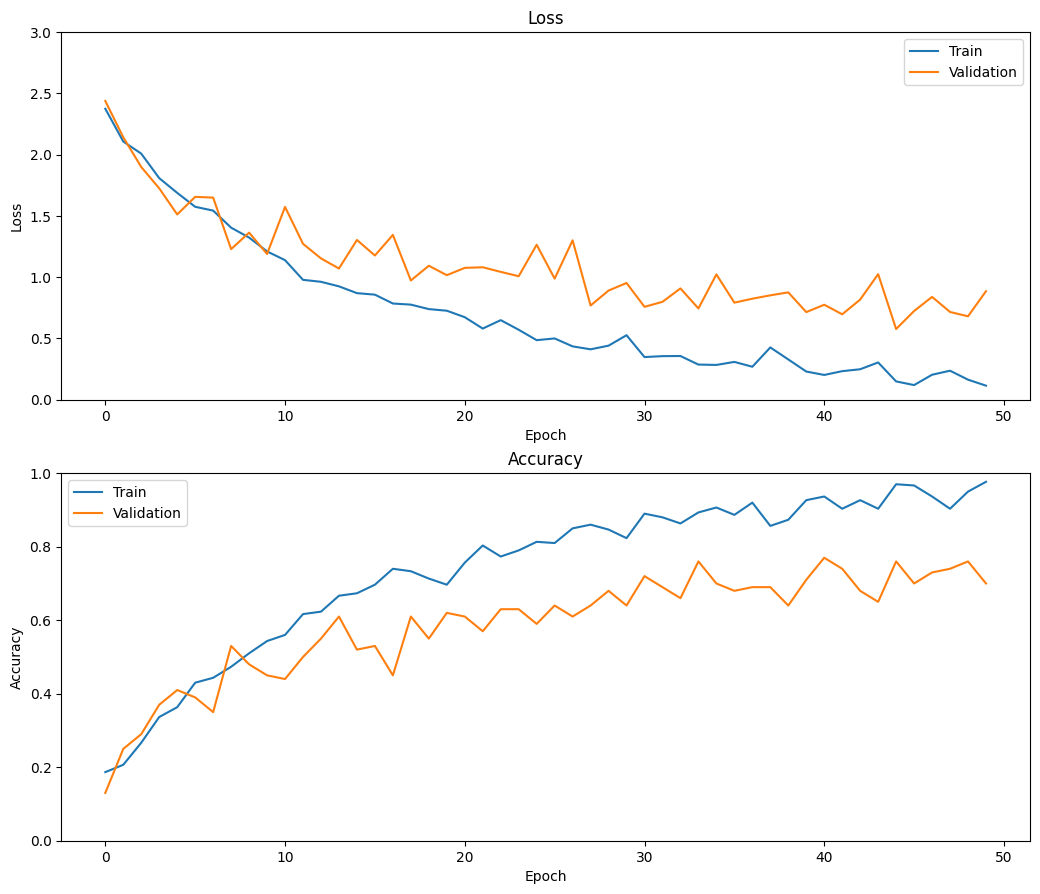

In [19]:
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(12.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

# Evaluating on test data

In [20]:
model.evaluate(test_ds, return_dict=True)

50/50 [==============================] - 15s 299ms/step - loss: 1.0235 - accuracy: 0.7000


{'loss': 1.023545503616333, 'accuracy': 0.699999988079071}

# Confusion matrix

In [26]:
def get_actual_predicted_labels(dataset):
      #Returns a Ground truth and predicted values for a particular dataset.
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

In [27]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt="g")
    sns.set(rc={"figure.figsize": (12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title("Confusion matrix of action recognition for " + ds_type)
    ax.set_xlabel("Predicted Action")
    ax.set_ylabel("Actual Action")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [28]:
fg = FrameGenerator(subset_paths["train"], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

150/150 [==============================] - 42s 276ms/step


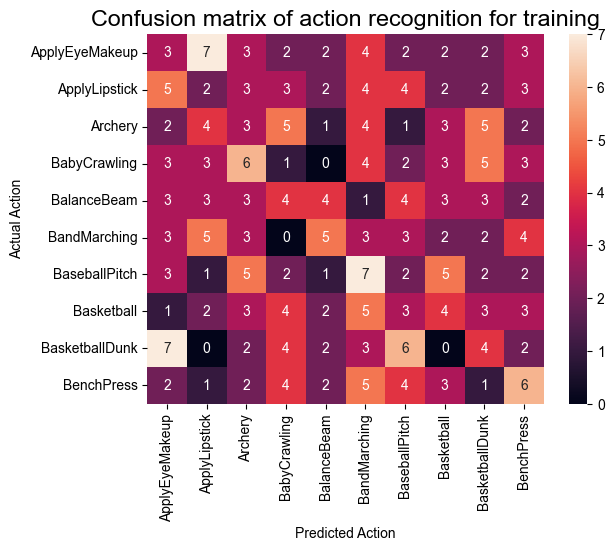

In [29]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, "training")

50/50 [==============================] - 14s 270ms/step


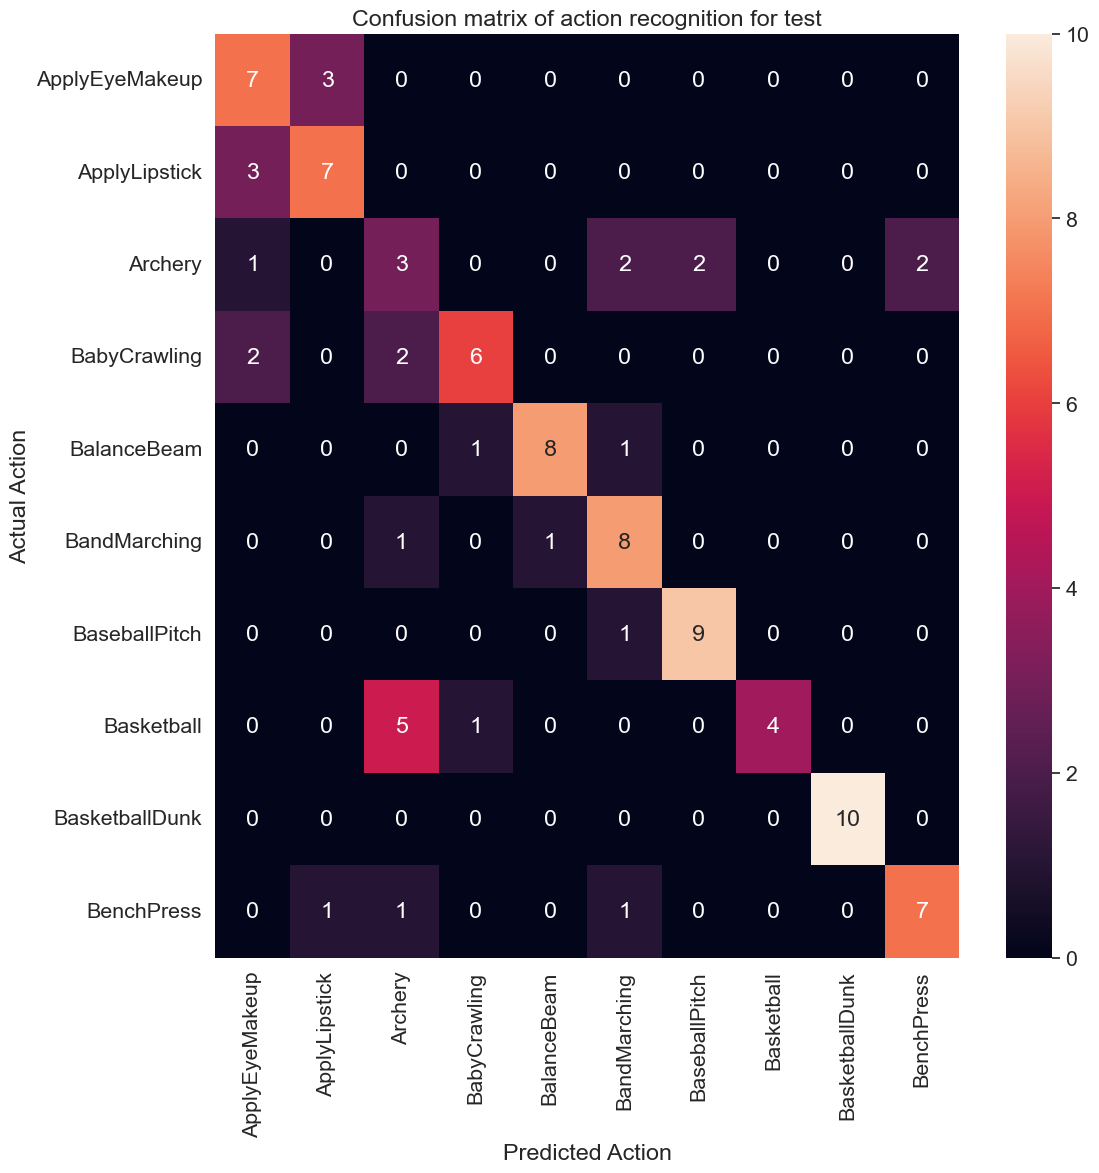

In [30]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, "test")